# **Studying the Black-Scholes-Merton (BSM) Model For Options Pricing**

This notebook is primarily a set of notes that I used to study the Black-Scholes-Merton model and attempt a very basic python implementation of this model.
Here, I learn what the BSM model is, what underlying assumptions it relies on, and where it is used.
***

## (1) Studying the BSM Model

### History and Principles
The BSM model was developed in 1973 by 3 people : Fischer Black, Robert Merton and Myron Scholes.

The model uses 6 variables to calculate model financial markets:
- Volatility
- Price of the underlying asset
- Strike price of the option
- Time until the expiration of the option
- Risk-free interest rate, and the type of option
- Whether it's a call or put
 
Using these, Black, Merton and Scholes modelled heavily traded assets as following a Geometric Brownian Motion (or a Wiener process).
This is a stochastic process in continuous time, called Brownian motion due to its historical relation to the physical process as observed in smoke particulates in air.

We will now briefly explore Wiener Processes.

#### Wiener Processes
A Wiener process can be thought of and constructed as the scaling limit of a 1 dimensional random walk.
In easier terms, a Wiener process is the expected behaviour of a random walk along a number line, as the distance between each step reduces.

An example of a 1D random walk could be a walk over the integers ℤ, where we start a pointer at 0, and each "turn", there is an equal probability $p$ of going $x$ to the right or left.

Since the Wiener process is the scaling limit of the 1D random walk, a random walk with small enough steps can be used to approximate the process.

Namely, if the step size is $\epsilon$ then, walking a length of $\dfrac{L}{\epsilon^2}$ is adequate to approximate a Wiener process of length $L$.

As $\epsilon$ tends to 0 and the number of steps increase, the random walk converges to a Wiener Process.

We can model a random walk in Python

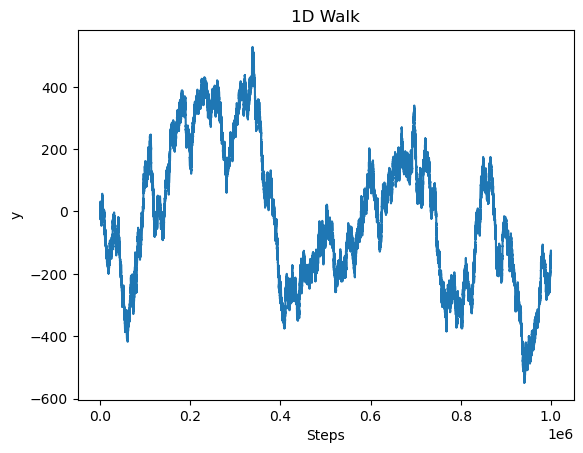

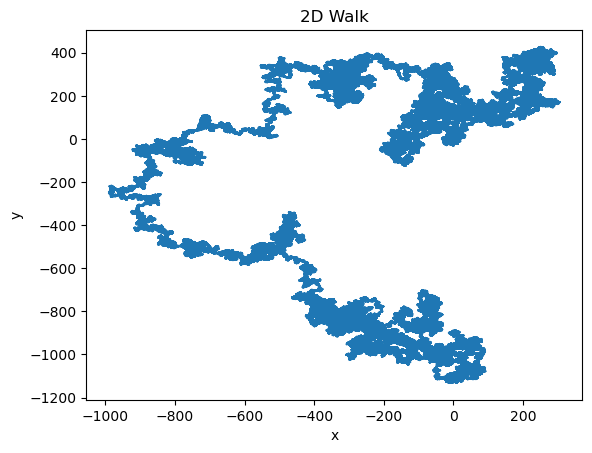

In [17]:
# Model of 1D/2D Random Walks

# imports
import matplotlib.pyplot as plt
from random import randint as r

def step1D(n=1000000, e=1):

    # We start at origin (0,0), so create arrays for x and y values, starting with (0,0)
    x_val = [0]
    y_val = [0]

    # Start for loop to fill in the coordinate values for n steps.
    for i in range(n):

        # Filling the values based on a random value r:
        random = r(1,2)
        x_val.append(x_val[i]+1)

        # There's an equal probability of 2 different possible cases occurring.
        if random == 1:
            y_val.append(y_val[i]+e)
            
        elif random == 2:
            y_val.append(y_val[i]-e)

    return x_val,y_val

# We define a function steps to increase/decrease the (x,y) values by certain increments each "turn"
# Takes inputs n - number of steps, e - increment value
def step2D(n=1000000, e=1):

    # We start at origin (0,0), so create arrays for x and y values, starting with (0,0)
    x_val = [0]
    y_val = [0]

    # Start for loop to fill in the coordinate values for n steps.
    for i in range(n):

        # Filling the values based on a random value r:
        random = r(1,4)

        # There's an equal probability of all 4 different possible cases occurring.
        if random == 1:
            x_val.append(x_val[i]+e)
            y_val.append(y_val[i])
            
        elif random == 2:
            x_val.append(x_val[i])
            y_val.append(y_val[i]+e)

        
        elif random == 3:
            x_val.append(x_val[i]-e)
            y_val.append(y_val[i])
            
        else:
            x_val.append(x_val[i])
            y_val.append(y_val[i]-e)

    return x_val,y_val

# Mainline code
x1,y1 = step1D()
plt.plot(x1,y1)
plt.title("1D Walk")
plt.ylabel('y')
plt.xlabel('Steps')
plt.show()

x2,y2 = step2D()
plt.plot(x2,y2) 
plt.title("2D Walk")
plt.ylabel('y')
plt.xlabel('x')
plt.show()



In this implementation, the probability of any movement $e$ up, down, left or right in the 2D plane is given by a probability function such that:
$$
P(X=x) = \dfrac{1}{4} : x\in\{\text{1, 2, 3, 4}\}
$$
Where:
$$ x=\left\{
\begin{array}{ll}
      1 & \text{Add e to x value} \\
      2 & \text{Add e to y value} \\
      3 & \text{Subtract e from x value} \\
      4 & \text{Subtract e from y value} \\
\end{array} 
\right.
$$

This can be used to model a Wiener process.

First, we formulate the key properties of a Wiener process:
- $W_0=0$ almost surely
- $W$ has independent increments; for every t>0, the future increments $W_{t+u}-W_t$ , $u\geq 0$, are independent of the past values $W_s$, $s<t$.
- $W$ has Gaussian increments; $W_{t+u}-W_t$ is normally distributed with mean $0$ and variance $u$, $W_{t+u}-W_t \sim N(0,u)$
- $W$ has almost surely continuous paths; $W_t$ is almost surely continuous in $t$.

Now, the idea of a Wiener process being the continuum limit of a random walk will make more sense.

Let $\xi_1,\xi_2,...$ be a sequence independent, identically distributed random variables with mean 0 and variance 1.
For each $n \geq 1$, we can define a random walk by:
$$
S_n(t) = \sum_{1\leq i \leq \lfloor nt \rfloor}\xi_i
$$
We can then write the rescaled random walk as:
$$
W_n(t) = \dfrac{1}{\sqrt{n}}S_n(t) =\dfrac{1}{\sqrt{n}}\sum_{1\leq i \leq \lfloor nt \rfloor}\xi_i
$$
In accordance with Donsker's Theorem, this is a random step function, a sequence of which define a scaled and centred random walk.

We can set $W_0$ to be $0$, fulfilling the first property of a Wiener process.

Since each $\xi$ is independent, each increment is independent.

It is not difficult to see that as $n \rightarrow \infty$, $W_n(t)-W_n(s) \rightarrow N(0,t-s)$ by the central limit theorem, thus Gaussian increments are observed.

As $n \rightarrow \infty$, $\dfrac{1}{\sqrt{n}} \rightarrow 0$, so each step will become so small, the function is essentially continuous.

Thus, a random walk can be used to approximate a Wiener process.

***

### Deriving the BSM Equation


In order to derive the BSM equation, we need 1 key assumption, that is that the dervative is being traded on a **frictionless market**, which refers to a financial market without transaction costs. This gives us "perfect information", in which we essentially have a complete knowledge of market prices, our own utility and our cost functions.

Thus, the price of a stock follows Geometric Brownian Motion:
$$
\text{d}S = \mu S \text{ d}t + \sigma S \text{ d}W
$$
Where $S$ is the stock price as a function of $t$, $t$ is time, $\sigma$ is volatility and $W$ is the stochastic variable under brownian motion. Since d$W$ is the infinitesimal increment, it's equivalent to a Gaussian increment as observed under the Weiner Process.

The equation above also essentially states that the infinitesimal rate of return of the stock has an expected value of $\mu \text{ d}t$ and variance of $\sigma^2 \text{ d}W$.

This is by Itô's lemma which states that for any equation of the form:
$$
\text{d} X_t = \mu_t\text{ d}t + \sigma_t \text{ d}B_t
$$
Where $B_t$ is a Wiener process and $\mu$ and $\sigma$ are deterministic functions of t.

We can formally write an integral solution:
$$
X_t = \int^t_0 \mu_s \text{ d}s + \int^t_0 \sigma_s \text{ d}B_t
$$
From which we can easily read off the mean and variance, as the mean each d$B_t$ is 0 and the variance is 1.

The function $V(t,S)$ is the price of an option based on the time $t$ and stock price $S$. We know the maturation time of this option, $T$ and it has payoff $K(S_T)$ based on $S_T$ which is the price of the underlying asset $S$ at $T$.

We know the payoff $V(T,S)$ at maturity, but to find its price at an earlier time, we need to know how $V$ evolves with respects to $S$ and $t$. By Itô's lemma for two variables (which is very complicated - will not be covered here):
$$
\text{d}V =\left(\mu S\dfrac{\partial V}{\partial S}+\dfrac{\partial V}{\partial t}+\dfrac{1}{2}\sigma^2S^2\dfrac{\partial^2 V}{\partial S^2}\right)\text{d}t+\sigma S\dfrac{\partial V}{\partial S}\text{d}W
$$
Replacing the differentials with deltas gives:
$$
\Delta S = \mu S \Delta t + \sigma S \Delta W
$$
$$
\Delta V =\left(\mu S\dfrac{\partial V}{\partial S}+\dfrac{\partial V}{\Delta t}+\dfrac{1}{2}\sigma^2S^2\dfrac{\partial^2 V}{\partial S^2}\right)\Delta t+\sigma S\dfrac{\partial V}{\partial S}\Delta W
$$

Now, we consider a portofolio $\Pi$ consisting of a short option and $\dfrac{\partial V}{\partial S}$ long shares at time $t$. The value of these holdings is:
$$
\Pi = -V + \dfrac{\partial V}{\partial S}S
$$

Over the time period $[t,t+\Delta t]$, the total profit or loss from changes in the values of the holdings is:
$$
\Delta\Pi = -\Delta V + \dfrac{\partial V}{\partial S}\Delta S
$$
Now, we can substitute $\Delta V$ and $\Delta S$ into this equation and simplify, leaving:
$$
\Delta\Pi = \left(-\dfrac{\partial V}{\partial t}-\dfrac{1}{2}\sigma^2 S^2\dfrac{\partial^2V}{\partial S^2}\right)\Delta t
$$
**Importantly**, the $W$ term has vanished, so the uncertainity has been removed and the portfolio is essentially riskless.

So, the rate of return on this portfolio must be equal to the rate of return on any other riskless instrument; otherwise, there would be opportunities for arbitrage. So, assuming the risk-free rate of return is $r$ we must have over the time period $[t,t+\Delta t]$:
$$
\Pi = r\Pi\Delta t
$$
So, we substitute for $\Pi$ and $\Delta\Pi$, and get:
$$
\left(-\dfrac{\partial V}{\partial t}-\dfrac{1}{2}\sigma^2 S^2\dfrac{\partial^2V}{\partial S^2}\right)\Delta t = r\left(-V + \dfrac{\partial V}{\partial S}S\right)\Delta t
$$
Simplifying, we get:
$$
\dfrac{\partial V}{\partial t}+rS\dfrac{\partial V}{\partial S}+\dfrac{1}{2}\sigma^2 S^2\dfrac{\partial^2V}{\partial S^2} = rV
$$
Which is the Black-Scholes-Merton equation as a partial differential equation.

Essentially, since risk in the form of $W$ completely disappears, once can perfectly hedge the option by buying and selling the underlying asset in such a way as to completely eliminate risk. Thus, there is exactly 1 correct options price, as given by the BSM Equation.
***

### Getting to the BSM Model

The BSM model relies on a few key assumptions about the market and underlying asset.

Markets have the following properties:
- Frictionless : So no transaction fees or costs.
- No-arbitrage : There is no way for investors to make "riskless" profit.
- Allow investors to borrow and lend any amount, even fractional, of cash at the riskless-rate.
- Allow investors to buy and sell any amount, even fractional, of the asset.

Assets have the following properties:
- Riskless-rate : The riskless asset (cash, bonds) has a fixed rate of return, called the riskless-rate.
- Random Walk : The instantaneous return of the risky asset is an infinitesimal random walk with drift; the asset price follows a geometric brownian motion, and it is assumed that drift and volatility are constant values. If they are not, then a suitable formulation of the BSM formula can be deduced so long as volatility is not random.
- Assets pay no dividends.

With these, we assume there is a derivative security trading in the market, such that there is a certain payoff at a future date and time, maturity, dependent on the values the stock takes up to then.

While the path the stock will make is unknown for the future, the derivatives price can be and is determined in the current time.

In the case of European call or put options, Black and Scholes demonstrated that a hedged position can be taken through a long position in the risky asset and a short position in the option, which is independent of the price of the stock. This led to the BSM equation earlier, which governs the price of said option.

Note : Many of the assumptions including dynamic interest, transaction costs, taxes and dividend payouts have been removed in future extensions and revisions of the model.

From the BSM Equation, we can solve using boundary conditions:
- $C(0,t) = 0\text{, }\forall t$
- $C(S,t \rightarrow S-K \text{ as }S\rightarrow \infty$
- $C(S,T)=\max(S-K, 0)$

Where $C(S,t)$ is the price of a European call option at time $t$ in relation to the asset price $S$.

(This is real hard, so I'm not going to try to write the solution method)

Solving, we get:
$$
C(S,t) = N(d_+)S_t - N(d_-)Ke^{-r(T-t)}
$$
$$
d_+ = \dfrac{1}{\sigma\sqrt{T-t}}\left[\ln(\dfrac{S_t}{K})+\left(r+\dfrac{\sigma^2}{2}\right)(T-t)\right]
$$
$$
d_- = d_+ - \sigma\sqrt{T-t}
$$
Where $N()$ is the standard normal cumulutive distribution function.

By put-call parity, the price of a corresponding put option, $P(S_t,t)$, is:
$$
p(S,t) = N(-d_-)Ke^{-r(T-t)} - N(-d_+)S_t
$$

We can also simplify this formula by introducing auxillary variables, which makes the formula easier to use and understand:
$$
C(S, \tau) = D[N(d_+)F-N(d_-)K]
$$
$$
d_+ = \dfrac{1}{\sigma\sqrt{\tau}}\left[\ln(\dfrac{F}{K})+\dfrac{1}{2}\sigma^2\tau\right]
$$
$$
d_- = d_+-\sigma\sqrt{\tau}
$$
Where $D = e^{-r\tau}$ is the discount factor.

$F = \dfrac{S}{D}$ is the forward price of the underlying asset.

This can be confusing, but is not as daunting as it looks.

First, we break down the call option into binary options, an asset-or-nothing call (at maturity an asset is yielded if above strike price) and a cash-or-nothing call (at maturity a sum of cash is yielded if above strike price).

The BSM formula can then be thought of as a difference of these options:
$$
C(S,t) = D[N(d_+)F-N(d_-)K]
$$
Where $DN(d_+)F$ is the present value of an asset-or-nothing call and $DN(d_-)K$ is the present value of a cash-or-nothing call.

In this, $D$ is the discount factor that is required as expiration is in the future. If $D$ is removed, however, then the present values change to future values. This yields the expected value of the asset and the expected value of cash in the risk-neutral measure.

## (2) Implementing the BSM Model in Python

Initially, we'll define the functions for put and call options.

In [6]:
#Imports
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

#Defining the Normal Cumulative Distribution Function as N
N = sc.stats.norm.cdf

#Defining functions for Call and Put options
def CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + ((r+sigma**2)/2)*T) / (sigma*np.sqrt(T)) #This is d- for CALL options
    d2 = d1 - sigma*np.sqrt(T) #This is d- for CALL options
    return S*N(d1)-K*np.exp(-r*T)*N(d2) #This is the formula for CALL options

def PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + ((r+sigma**2)/2)*T) / (sigma*np.sqrt(T)) #This is d+ for PUT options
    d2 = d1 - sigma*np.sqrt(T) #This is d- for PUT options
    return -S*N(-d1)+K*np.exp(-r*T)*N(-d2) #This is the formula for PUT options

Here, we take the following variables:
- N = Normal Cumulative Distribution Function
- S = Stock/Underlying asset price
- K = Strike Price
- T = Number of days between current time and maturity
- r = Interest rate on non-risky asset (cash)
- sigma = Volatility


We can now see what happens as we vary constants and variables.

### S effect on Options Value

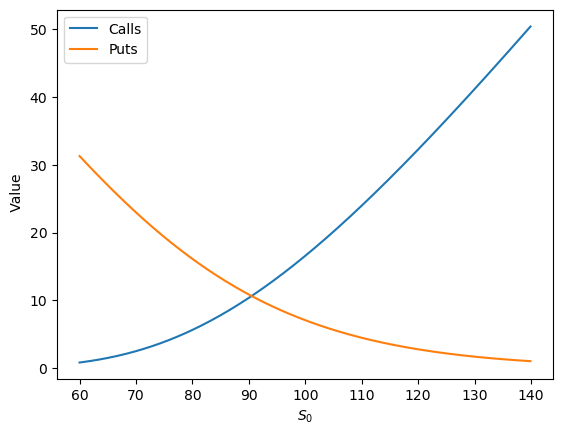

In [28]:
S = np.arange(60,140,0.1)
K = 100
T = 1
r = 0.1
sigma = 0.3

calls = [CALL(s,K,T,r,sigma) for s in S]
puts = [PUT(s,K,T,r,sigma) for s in S]

plt.plot(S, calls, label='Calls')
plt.plot(S, puts, label='Puts')
plt.xlabel('$S_0$')
plt.ylabel(' Value')
plt.legend()

This is what is expected, we know that at maturation, the return is based on the difference between strike price and asset price. So, if the initial value of the underlying asset is significantly higher than the strike price, its very likely that the return on a call option will be greater than 0,and vice versa for put options.

Thus, the option's price should be higher below $K$ and lower above $K$ for puts (as when lower, the expected result is in the money, and above, expected result is not in the money), and the opposite for calls.

Thus, this graph is expected.

### $\sigma$ effect on Black-Scholes Value

As expected, when volatility is increased, both call and put options increase in value in what seems to be a linear fashion. This seems to make sense, as we'd want the options pricing to be greater when the future is more uncertain.

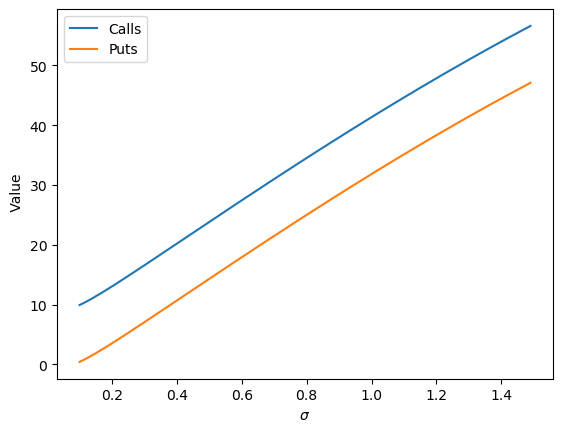

In [32]:
S = 100
K = 100
T = 1
r = 0.1
sigmas = np.arange(0.1,1.5,0.01)

calls = [CALL(S,K,T,r,s) for s in sigmas]
puts = [PUT(S,K,T,r,s) for s in sigmas]

plt.plot(sigmas, calls, label='Calls')
plt.plot(sigmas, puts, label='Puts')
plt.xlabel('$\sigma$')
plt.ylabel(' Value')
plt.legend()

To see why calls seems to be valued above puts for all volatilities, let us vary the interest.

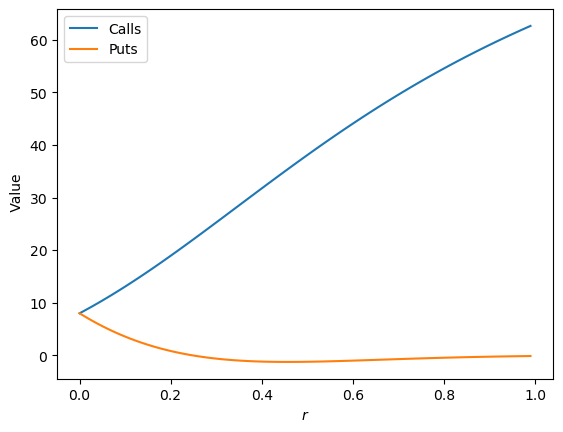

In [34]:
S = 100
K = 100
T = 1
rs = np.arange(0,1,0.01)
sigma = 0.2
calls = [CALL(S,K,T,R,sigma) for R in rs]
puts = [PUT(S,K,T,R,sigma) for R in rs]

plt.plot(rs, calls, label='Calls')
plt.plot(rs, puts, label='Puts')
plt.xlabel('$r$')
plt.ylabel(' Value')
plt.legend()

So, we deduce that increasing interest rates increases the valuation of call options, and decreases the valuation of put options.

This makes sense, as higher interest means more valuation of the non-risky asset, so less chance of the result being not in the money.

### Effects of Time on Black-Scholes Prices

We know that when $T$ is small, the uncertainity of the future is low, so the options price should reflect this, with call and put options being valued at similar values.

But when $T$ increases, the valuation of put and calls spread apart, since the uncertainty brings risk, so the fair price for put/call options spread apart.

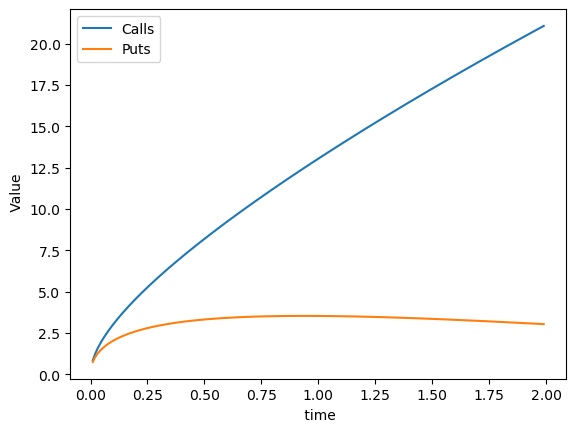

In [38]:
S = 100
K = 100
Ts = np.arange(0.01,2,0.01)
r = 0.1
sigma = 0.2
calls = [CALL(S,K,t,r,sigma) for t in Ts]
puts = [PUT(S,K,t,r,sigma) for t in Ts]

plt.plot(Ts, calls, label='Calls')
plt.plot(Ts, puts, label='Puts')
plt.xlabel(' time')
plt.ylabel(' Value')
plt.legend()

As time increases, the probability of being in the money for call options increases, as the interest rate adds to the value of the non-risky asset, and uncertainty benefits the options holder, so to maintain fair prices, the prices rise.

This is true for put options for a period of time too, as the price of put options rise to offset uncertainty which benefits offer holders, but the valuation of put options quickly drops as interest renders the likelihood of being in the money lower for puts.

## (3) Limitations of the BSM Model

### Constant Volatility

One key limitation of the BSM Model is the assumption that volatility remains (relatively) constant throughout the time period that the option is valid.

Here we can look at an example

Standard Deviation across whole:  0.283


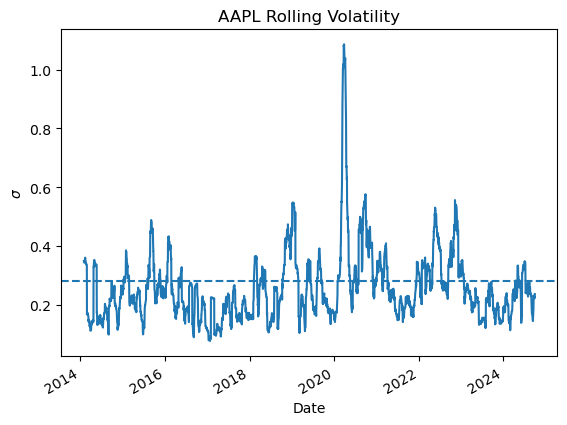

In [43]:
import yfinance as yahooFinance
import pandas as pd
import datetime as dt

ticker = yahooFinance.Ticker("AAPL")

start_date = dt.datetime(2014,1,1)
end_date = dt.datetime(2024,10,1)

data = ticker.history(start=start_date,end=end_date)
values = data["Close"]
change = values.pct_change()
rolling_sigma = change.rolling(20).std() * np.sqrt(255)
sigma = np.std(change)*np.sqrt(255)

rolling_sigma.plot()
plt.ylabel('$\sigma$')
plt.title('AAPL Rolling Volatility')
plt.axhline(y = sigma, linestyle = '--') 
print("Standard Deviation across whole: ", round(sigma,3))

In the historical case of Apple, the annual volatility given for the time period 2014 - 2024 is given as $0.283$, but this is obviously not constant, and the BSM model does not account for the unexpected spike in volatility in 2020.

This is therefore a key limitation of the BSM model.

### Implied Volatility

Of all the variables used in the BSM model, the one variable that cannot be known at the time of calculation is future volatility. As outlined above, the future movement and changes in volatility are never known, so inputting future volatility for any period of time beyond instantaneous is impossible.

The way we deal with this is by considering implied volatility, which is essentially instantaneous volatility.

We do this by inputting the current market price of the option into the BSM Formula and back-solving for $\sigma$

In [7]:
def ImpVolC(C,S,K,t,r,sigma):
    x=True
    while x==True:
        Cr = CALL(S,K,t,r,sigma)
        if C > Cr:
            sigma += 0.0025
        else:
            x=False
    return sigma, Cr

def ImpVolP(C,S,K,t,r,sigma):
    x= True
    while x==True:
        Cr = PUT(S,K,t,r,sigma)
        if C > Cr:
            sigma += 0.0025
        else:
            x=False
    return sigma, Cr

This works by underestimating a value of $\sigma$, and since value increases as volatility increases, we increase volatility slowly until the calculated option value is greater than or equal to the real call value.

The python function then returns the calculated value and the implied volatility.

In [11]:
S = 150
K = 100
t = 1
r = 0.01
sigma = 0.0025
C = 100

print(ImpVolC(C,S,K,t,r,sigma))

(1.6274999999999764, 100.08117993664143)


This is obviously still modelled as constant, but it is better than using a value that only holds for historical data or for prices in the past.